In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import os

# Paths
MODEL_PATH = r"C:\Users\syeda\Desktop\code\Crash Detection\Test Dataset\crash_cnn_model.h5"
VIDEO_PATH = r"C:\Users\syeda\Desktop\code\Crash Detection\test_video4.mp4"


In [17]:
# Load trained CNN model
cnn_model = load_model(MODEL_PATH)
print("✅ CNN model loaded.")

# Load YOLOv8 model
yolo_model = YOLO("yolov8n.pt")
print("✅ YOLOv8 model loaded.")


✅ CNN model loaded.
✅ YOLOv8 model loaded.


In [18]:
def preprocess_crop(crop):
    crop_resized = cv2.resize(crop, (128, 128)) / 255.0
    crop_input = np.expand_dims(crop_resized, axis=0)
    return crop_input


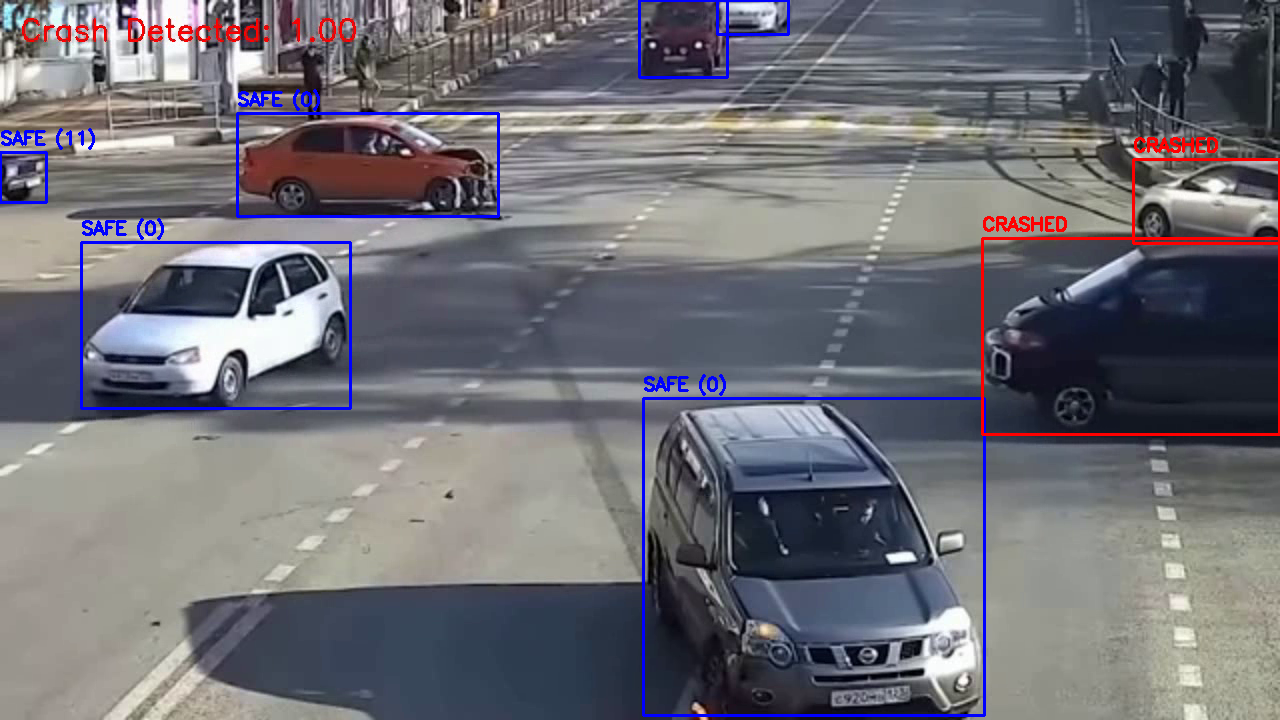

🎬 Video playback complete.


In [14]:
from collections import deque
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from IPython.display import display, clear_output
from PIL import Image

# Load models
yolo_model = YOLO("yolov8n.pt")
cnn_model = load_model(MODEL_PATH)

vehicle_crash_score = {}
vehicle_crashed = {}
vehicle_frame_count = {}
vehicle_prev_pos = {}
vehicle_trackers = {}
crashed_positions = {}
crashed_crops = {}  # Store only the first crash frame per car
vehicle_was_moving = {}
crash_persistence = {}

# Stricter thresholds
CRASH_CONF_THRESHOLD = 0.9
FRAME_CONFIRMATION_THRESHOLD = 25
CRASH_PERSISTENCE_FRAMES = 6
MIN_FRAMES_BEFORE_CRASH = 5
MOVEMENT_THRESHOLD = 5
OCCLUSION_DISTANCE_THRESHOLD = 50
MOVING_AWAY_THRESHOLD = 3

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print("❌ Error: Could not open video.")
else:
    print("✅ Video opened successfully.")

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("🎬 Video playback complete.")
        break

    frame_count += 1
    results = yolo_model.track(frame, persist=True, verbose=False)[0]

    for box in results.boxes:
        cls = int(box.cls[0])
        if results.names[cls] != "car":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        if conf < 0.4:
            continue

        obj_id = int(box.id[0]) if box.id is not None else f"{x1}-{y1}-{x2}-{y2}"
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        crop_resized = cv2.resize(crop, (128, 128)) / 255.0
        crop_input = np.expand_dims(crop_resized, axis=0)
        pred_vec = cnn_model.predict(crop_input, verbose=0)[0]
        raw_pred = pred_vec[1]

        if obj_id not in vehicle_crash_score:
            vehicle_crash_score[obj_id] = 0
            vehicle_crashed[obj_id] = False
            vehicle_frame_count[obj_id] = 0
            vehicle_prev_pos[obj_id] = (0,0)
            vehicle_trackers[obj_id] = deque(maxlen=8)
            vehicle_was_moving[obj_id] = False
            crash_persistence[obj_id] = 0

        # Always check crashed state first
        if vehicle_crashed[obj_id]:
            color = (0, 0, 255)
            label = "CRASHED"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        vehicle_frame_count[obj_id] += 1

        if vehicle_frame_count[obj_id] < MIN_FRAMES_BEFORE_CRASH:
            color = (255, 255, 0)
            label = "INITIALIZING"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        prev_cx, prev_cy = vehicle_prev_pos[obj_id]
        dx = cx - prev_cx
        dy = cy - prev_cy
        movement = np.hypot(dx, dy)
        vehicle_prev_pos[obj_id] = (cx, cy)

        # Track if car was moving recently
        if movement >= MOVEMENT_THRESHOLD:
            vehicle_was_moving[obj_id] = True

        # Check for collision with crashed car (overlap)
        overlaps_crashed = False
        for crashed_id, pos in crashed_positions.items():
            dist = np.hypot(pos[0] - cx, pos[1] - cy)
            if dist < OCCLUSION_DISTANCE_THRESHOLD:
                overlaps_crashed = True
                break

        # Stationary car crash logic
        if movement < MOVEMENT_THRESHOLD:
            if not vehicle_was_moving[obj_id] and not overlaps_crashed:
                color = (0, 255, 255)
                label = f"STATIONARY ({vehicle_crash_score[obj_id]})"
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 8),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                continue

        if dx > MOVING_AWAY_THRESHOLD:
            color = (0, 255, 255)
            label = "MOVING AWAY"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        vehicle_trackers[obj_id].append(raw_pred)
        smoothed_pred = np.mean(vehicle_trackers[obj_id])

        # Crash scoring
        if smoothed_pred > CRASH_CONF_THRESHOLD:
            vehicle_crash_score[obj_id] += 1
        else:
            vehicle_crash_score[obj_id] = max(0, vehicle_crash_score[obj_id] - 1)

        # Confirm crash and require persistence
        if vehicle_crash_score[obj_id] >= FRAME_CONFIRMATION_THRESHOLD:
            crash_persistence[obj_id] += 1
            if crash_persistence[obj_id] == CRASH_PERSISTENCE_FRAMES and obj_id not in crashed_crops:
                vehicle_crashed[obj_id] = True
                crashed_positions[obj_id] = (cx, cy)
                crashed_crops[obj_id] = crop.copy()
            color = (0, 0, 255)
            label = f"CRASH CONFIRMED ({vehicle_crash_score[obj_id]})"
        else:
            crash_persistence[obj_id] = 0
            color = (255, 0, 0)
            label = f"SAFE ({vehicle_crash_score[obj_id]})"

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show every frame in notebook
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    display(Image.fromarray(rgb_frame))

cap.release()


Crashed car images (one per car):


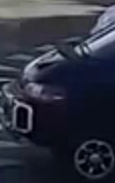

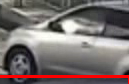

In [15]:
print("Crashed car images (one per car):")
for obj_id, crop_img in crashed_crops.items():
    display(Image.fromarray(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)))